## To do:

BEST FOR NOW 0.832

- Cross Validation
- Si titre pas bon (Que des stopwords) cf 9608115, Il faut faire quelque chose. Remplacer les titres pas bons par les mots de l'abstract avec tfidf le plus fort, poru le nombre de mots, moyenne (cf dans la fonction)
--> Essayer abstract, essayer meilleurs tfidf et prendre le meilleur

    - Sans le tfidf abstract : 0.832
    - Sans titre : 0.823
    - tfidf : 
    
    
- Vérifier que ce n'est pas mieux avec overlap abstract et overlap title
- Graph
- J'ai l'impression qu'on ne stem pas.. à voir 
- Essayer de retirer tous les outliers (pas de titre, pas de journal) avant de trainer

In [498]:
import random
import numpy as np
import igraph
from sklearn import svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics import f1_score
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
import nltk
import csv
import pandas as pd
import xgboost as xgb

In [378]:
from nltk.cluster.util import cosine_distance
nltk.download('punkt') # for tokenization
nltk.download('stopwords')
stpwds = set(nltk.corpus.stopwords.words("english"))
stemmer = nltk.stem.PorterStemmer()

[nltk_data] Downloading package punkt to /Users/Jenny/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/Jenny/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


note: Kaggle requires that you add "ID" and "category" column headers

# Feature Engineering

### Data loading and preprocessing 

In [414]:
with open("training_set.txt", "r") as f:
    reader = csv.reader(f)
    training_set  = list(reader)

training_set = [element[0].split(" ") for element in training_set]

In [415]:
with open("node_information.csv", "r") as f:
    reader = csv.reader(f)
    node_info  = list(reader)

IDs = [element[0] for element in node_info]

### Clean and preparing the set

##### Inputing missing titles

Mean of number of words in titles

In [381]:
np.mean([len(el[2].split(' ')) for el in node_info])

7.5944544472452282

There are in average 8 words in every title. Without stopwords, we consider 5 the number of words to input.

In [382]:
def find_best_from_abstract(abstract, n = 5):
    vectorizer = TfidfVectorizer(stop_words="english")
    # each row is a node in the order of node_info
    features_TFIDF = vectorizer.fit_transform([abstract])
    indices = np.argsort(vectorizer.idf_)[::-1]
    features = vectorizer.get_feature_names()
    top_features = [features[i] for i in indices[:n]]
    title = ""
    for el in top_features:
        title+=el+" "
    return title

Input titles for missing titles or too short titles.

In [383]:
for i in range(len(node_info)):
    if len(node_info[i][2]) < 3:
        node_info[i][2] = find_best_from_abstract(node_info[i][5])

##### Graph

Create a graph

In [384]:
edges = [(element[0],element[1]) for element in training_set if element[2]=="1"]
nodes = IDs

g = igraph.Graph(directed=True)
g.add_vertices(nodes)
g.add_edges(edges)

In [385]:
list_indegrees = g.indegree()
list_outdegrees = g.outdegree()
cores = g.shell_index()

Compute tfidf for each graph

In [386]:
corpus = [element[5] for element in node_info]


vectorizer = TfidfVectorizer(stop_words="english")
# each row is a node in the order of node_info
features_TFIDF = vectorizer.fit_transform(corpus)

tfidf_matrix_abstract = features_TFIDF.toarray() #line : abstract, column : mot

In [387]:
svd = TruncatedSVD(n_components = 100)
svdMatrix_abstract = svd.fit_transform(tfidf_matrix_abstract)

In [388]:
corpus = [element[2] for element in node_info]
vectorizer = TfidfVectorizer(stop_words="english")

features_TFIDF = vectorizer.fit_transform(corpus)
tfidf_matrix_title = features_TFIDF.toarray() #line : abstract, column : mot

In [389]:
svd = TruncatedSVD(n_components = 100)
svdMatrix_title = svd.fit_transform(tfidf_matrix_title)

##### Similarity matrix

In [390]:
def find_similarity_lsa(index_source, index_target, svdMatrix):
    vector1 = svdMatrix[index_source]
    vector2 = svdMatrix[index_target]
    
    lsa = cosine_distance(vector1, vector2)
    if np.isnan(lsa):
        return 0.0
    else:
        return 1 - lsa

In [391]:
def find_similarity_tfidf_abstract(index_source, index_target):
    
    vector1 = tfidf_matrix_abstract[index_source]
    vector2 = tfidf_matrix_abstract[index_target]
    
    cos = cosine_distance(vector1, vector2)
    if np.isnan(cos):
        return 0.0
    else:
        return 1 - cos

In [392]:
def find_similarity_tfidf_title(index_source, index_target):
    
    vector1 = tfidf_matrix_title[index_source]
    vector2 = tfidf_matrix_title[index_target]
    
    cos = cosine_distance(vector1, vector2)
    if np.isnan(cos):
        return 0.0
    else:
        return 1 - cos

In [393]:
# tentative d'utiliser seulement les deux textes au lieu du corpus, mais moins bien
def cosine_sim(text1, text2):
    tfidf = vectorizer.fit_transform([text1, text2])
    return ((tfidf * tfidf.T).A)[0,1]

In [394]:
def find_similarity(source, target):
    all_words = list(set(source + target))
    
    vector1 = [0] * len(all_words)
    vector2 = [0] * len(all_words)
    # build the vector for the first sentence
    for w in source:
        vector1[all_words.index(w)] += 1
    # build the vector for the second sentence
    for w in target:
        vector2[all_words.index(w)] += 1

    cos = cosine_distance(vector1, vector2)
    if np.isnan(cos):
        return 0.0 #ou 1???
    else:
        return 1 - cos

##### Transform journals' names in numerical categories

In [395]:
journals = list(set([el[4] for el in node_info]))
journ = {}
for i, j in enumerate(journals):
    journ[j] = i

## Create Features

In [396]:
def similarityNeighbors(index_source, index_target, sim_neighbors):
    res = []
    n = set(g.neighbors(index_target))
    if not n:
        sim_neighbors.append(0.0)
    else:
        for nei in n : 
            res.append(find_similarity_tfidf_abstract(nei, index_source))
        sim_neighbors.append(np.mean(res))

In [397]:
def commonNeighbors(index_source, index_target, comm_neighb):
    na = set(g.neighbors(index_source))
    nb = set(g.neighbors(index_target))
    comm_neighb.append(len(na.intersection(nb)))

In [398]:
# check if a citation is possible or not
def isPossible(source_info, target_info, is_possible):
    if int(source_info[1]) - int(target_info[1]) < 0:
            is_possible.append(-1)
    else:
        is_possible.append(0)

In [399]:
def overlapTitle(source_title, target_title, overlap_title):
    overlap_title.append(len(set(source_title).intersection(set(target_title))))

In [400]:
def tempDiff(source_info, target_info, temp_diff):
    temp_diff.append(int(source_info[1]) - int(target_info[1]))

In [401]:
def commAuthors(source_info, target_info, comm_auth):
    source_auth = source_info[3].split(",")
    target_auth = target_info[3].split(",")
    comm_auth.append(len(set(source_auth).intersection(set(target_auth))))

In [402]:
def tfidfTitle(source_title, target_title, source_info, target_info, index_source, index_target, tfidf_title):
    if not source_title:
        source_title = find_best_from_abstract(source_info[5])
    if not target_title:
        target_title = find_best_from_abstract(target_info[5])

    tfidf_title.append(find_similarity_tfidf_title(index_source, index_target))

In [403]:
def tfidfAbstract(index_source, index_target, tfidf_abstract):
    tfidf_abstract.append(find_similarity_tfidf_abstract(index_source, index_target))

In [404]:
def lsaTitle(index_source, index_target, lsa_title):
    lsa_title.append(find_similarity_lsa(index_source, index_target, svdMatrix_title))

In [405]:
def lsaAbstract(index_source, index_target, lsa_abstract):
    lsa_abstract.append(find_similarity_lsa(index_source, index_target, svdMatrix_abstract))

In [406]:
def numInOut(index_source, index_target, num_in, num_out):
    num_in.append(list_indegrees[index_target])
    num_out.append(list_outdegrees[index_source])

In [407]:
def makeCores(index_source, index_target, core_target, core_diff):
    a = cores[index_source]
    b = cores[index_target]
    core_target.append(b)
    core_diff.append(abs(a-b))

In [408]:
def makeJourn(source_info, target_info, journ_diff):

    a = source_info[4]
    b = target_info[4]
    #journ_source.append(journ[a])
    #journ_target.append(journ[b])
    if not a or not b:
        journ_diff.append(-1)
    elif journ[a] == journ[b]:
        journ_diff.append(0)
    else:
        journ_diff.append(1)

In [416]:
def createFeatures(curr_set):
    is_possible = []
    overlap_title = []
    temp_diff = []
    # number of common authors
    comm_auth = []
    # tfidf
    tfidf_abstract = []
    tfidf_title = []
    # number of entering nodes / leaving nodes
    num_in = []
    num_out = []
    #coreness of the cited article/considered article
    core_target = []
    core_diff = []
    #same journal
    journ_source = []
    journ_target = []
    journ_diff = []
    #number of common neighbors
    comm_neighb = []
    sim_neighbors = []
    #lsa similarity
    lsa_title = []
    lsa_abstract = []

    counter = 0
    for i in range(len(curr_set)):
        source = curr_set[i][0]
        target = curr_set[i][1]

        index_source = IDs.index(source)
        index_target = IDs.index(target)

        source_info = [element for element in node_info if element[0]==source][0]
        target_info = [element for element in node_info if element[0]==target][0]
        
        source_title = source_info[2].lower().split(" ")
        source_title = [token for token in source_title if token not in stpwds]
        source_title = [stemmer.stem(token) for token in source_title]

        target_title = target_info[2].lower().split(" ")
        target_title = [token for token in target_title if token not in stpwds]
        target_title = [stemmer.stem(token) for token in target_title]
        
        #Create features
        
        isPossible(source_info, target_info, is_possible)
        tempDiff(source_info, target_info, temp_diff)
        
        overlapTitle(source_title, target_title, overlap_title)
        commAuthors(source_info, target_info, comm_auth)
        
        tfidfTitle(source_title, target_title, source_info, target_info, index_source, index_target, tfidf_title)
        tfidfAbstract(index_source, index_target, tfidf_abstract)
        
        lsaTitle(index_source, index_target, lsa_title)
        lsaAbstract(index_source, index_target, lsa_abstract)
            
        numInOut(index_source, index_target, num_in, num_out)
        makeCores(index_source, index_target, core_target, core_diff)
        makeJourn(source_info, target_info, journ_diff)
        
        commonNeighbors(index_source, index_target, comm_neighb)
        similarityNeighbors(index_source, index_target, sim_neighbors)

        counter += 1
        if counter % 1000 == True:
            print (counter, "examples processsed")

    features = [is_possible, temp_diff, comm_auth, overlap_title, tfidf_title, tfidf_abstract, 
                num_in, num_out, core_target, core_diff, journ_diff,
               comm_neighb, sim_neighbors, lsa_title, lsa_abstract]
    return features

### Data Separation

In [419]:
# For the tests
to_keep = random.sample(range(len(training_set)), k=int(round(len(training_set)*0.10)))
all_set_reduced = [training_set[i] for i in to_keep]

X = [all_set_reduced[i][:2] for i in range(len(all_set_reduced))]
y = np.array([int(all_set_reduced[i][2]) for i in range(len(all_set_reduced))])

training_set_reduced, testing_set, labels_array, y_true = train_test_split(X, y, test_size = 0.5, random_state = 42)

In [418]:
#For the real testing set
with open("testing_set.txt", "r") as f:
    reader = csv.reader(f)
    testing_set  = list(reader)

testing_set = [element[0].split(" ") for element in testing_set]

### Training

In [420]:
all_features_train = createFeatures(training_set_reduced)

1 examples processsed
1001 examples processsed


/Users/Jenny/anaconda3/lib/python3.6/site-packages/nltk/cluster/util.py:133: RuntimeWarning: invalid value encountered in double_scalars
  sqrt(numpy.dot(u, u)) * sqrt(numpy.dot(v, v))))


2001 examples processsed
3001 examples processsed
4001 examples processsed
5001 examples processsed
6001 examples processsed
7001 examples processsed
8001 examples processsed
9001 examples processsed
10001 examples processsed
11001 examples processsed
12001 examples processsed
13001 examples processsed
14001 examples processsed
15001 examples processsed
16001 examples processsed
17001 examples processsed
18001 examples processsed
19001 examples processsed
20001 examples processsed
21001 examples processsed
22001 examples processsed
23001 examples processsed
24001 examples processsed
25001 examples processsed
26001 examples processsed
27001 examples processsed
28001 examples processsed
29001 examples processsed
30001 examples processsed


In [491]:
training_features = np.array(all_features_train).T #to array
training_features = preprocessing.scale(training_features) #scale

## Testing

In [422]:
#create the features for the test set
all_features_test = createFeatures(testing_set)

1 examples processsed


/Users/Jenny/anaconda3/lib/python3.6/site-packages/nltk/cluster/util.py:133: RuntimeWarning: invalid value encountered in double_scalars
  sqrt(numpy.dot(u, u)) * sqrt(numpy.dot(v, v))))


1001 examples processsed
2001 examples processsed
3001 examples processsed
4001 examples processsed
5001 examples processsed
6001 examples processsed
7001 examples processsed
8001 examples processsed
9001 examples processsed
10001 examples processsed
11001 examples processsed
12001 examples processsed
13001 examples processsed
14001 examples processsed
15001 examples processsed
16001 examples processsed
17001 examples processsed
18001 examples processsed
19001 examples processsed
20001 examples processsed
21001 examples processsed
22001 examples processsed
23001 examples processsed
24001 examples processsed
25001 examples processsed
26001 examples processsed
27001 examples processsed
28001 examples processsed
29001 examples processsed
30001 examples processsed


In [493]:
testing_features = np.array(all_features_test).T #to array
testing_features = preprocessing.scale(testing_features) #scale

SVM

In [497]:
# initialize basic SVM and train the model
clf = svm.SVC(probability = True)
clf.fit(training_features, labels_array)
pred_SVM = clf.predict(testing_features)

In [485]:
#pred_SVM = [el[1] for el in pred_SVM]

In [486]:
# score for the tests
f1_score( y_true , pred_SVM)

0.98565476190476198

Random Forest

In [487]:
clf = RandomForestClassifier(min_samples_split = 40, 
                            max_features = 5,
                            max_leaf_nodes = 20,
                            n_estimators = 400,
                            max_depth = 10,
                            min_samples_leaf = 10)
clf.fit(training_features, labels_array)
pred_RF = clf.predict(testing_features) #prediction

In [332]:
pred_RF = [el[1] for el in pred_RF]

In [488]:
# score for the tests
f1_score(y_true , pred_RF)

0.98514040677764203

In [189]:
# to export the prediction
predictions_RF = zip(range(len(testing_set)), pred_RF)
with open("predictions_RF.csv","w") as pred1:
    csv_out = csv.writer(pred1)
    csv_out.writerow(["ID", "category"])
    for row in predictions_RF:
        csv_out.writerow(row)

Extra Forest

In [429]:
clf = ExtraTreesClassifier(min_samples_split = 40, 
                            max_features = 5,
                            max_leaf_nodes = 20,
                            n_estimators = 400,
                            max_depth = 10,
                            min_samples_leaf = 10)
clf.fit(training_features, labels_array)
pred_EF = clf.predict(testing_features) #prediction

In [334]:
pred_EF = [el[1] for el in pred_EF]

In [430]:
# score for the tests
f1_score( y_true , pred_EF)

0.9676376355780254

In [93]:
# to export the prediction
predictions_EF = zip(range(len(testing_set)), pred_EF)
with open("predictions_EF.csv","w") as pred1:
    csv_out = csv.writer(pred1)
    csv_out.writerow(["ID", "category"])
    for row in predictions_EF:
        csv_out.writerow(row)

Adaboost

In [431]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [432]:
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                         algorithm="SAMME",
                         n_estimators=200)
bdt.fit(training_features, labels_array)
pred_AB = bdt.predict(testing_features)

In [433]:
# score for the tests
f1_score(y_true, pred_AB)

0.98714285714285721

LGBM

In [459]:
import lightgbm as lgb
d_train = lgb.Dataset(training_features, label=labels_array)
params = {}
params['learning_rate'] = 0.15
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'binary_logloss'
params['sub_feature'] = 0.5
params['num_leaves'] = 20
params['min_data'] = 25
params['max_depth'] = 10
clf = lgb.train(params, d_train, 500)

In [460]:
pred_LGBM = clf.predict(testing_features) #prediction

In [437]:
for i in range(0,len(pred_LGBM)):
    if pred_LGBM[i] >= .5:       # setting threshold to .5
        pred_LGBM[i] = 1
    else:  
        pred_LGBM[i] = 0

In [438]:
pred_LGBM=pred_LGBM.astype(int)

In [440]:
# score for the tests
f1_score(y_true, pred_LGBM)

0.98793103448275865

In [182]:
# to export the prediction
predictions_LGBM = zip(range(len(testing_set)), pred_LGBM)
with open("predictions_LGBM.csv","w") as pred1:
    csv_out = csv.writer(pred1)
    csv_out.writerow(["ID", "category"])
    for row in predictions_LGBM:
        csv_out.writerow(row)

XGBoost

In [469]:
import xgboost as xgb

gbm = xgb.XGBClassifier(learning_rate=0.1, n_estimators=350, max_depth=7, colsample_bytree=1, objective = 'binary:logistic' , nthread=8, silent=True)
gbm = gbm.fit(training_features, labels_array)
pred_XGB = gbm.predict(testing_features)

In [471]:
#pred_XGB = [el[1] for el in pred_XGB]

In [446]:
f1_score(y_true, pred_XGB)

0.98783860129047607

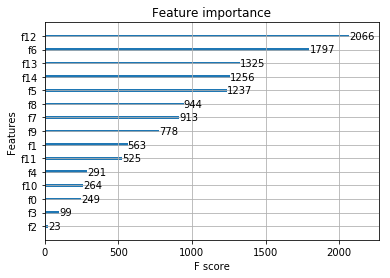

In [474]:
# plot feature importance using built-in function
from xgboost import plot_importance
from matplotlib import pyplot

# plot feature importance
plot_importance(gbm)
pyplot.show()

In [ ]:
# to export the prediction
predictions_XGB = zip(range(len(testing_set)), pred_XGB)
with open("predictions_LGBM.csv","w") as pred1:
    csv_out = csv.writer(pred1)
    csv_out.writerow(["ID", "category"])
    for row in predictions_XGB:
        csv_out.writerow(row)

Logistic Regression

In [454]:
clf = LogisticRegression(penalty = 'l1', C = 1, random_state = 5)
clf.fit(training_features, labels_array)
pred_LR = clf.predict_proba(testing_features) #prediction

In [455]:
pred_LR = [el[1] for el in pred_LR]

In [457]:
# score for the tests
f1_score( y_true , pred_LR)

Mix des résultats

In [347]:
pred = (np.array(pred_LR) + 
        np.array(pred_SVM) + 
        np.array(pred_RF) + 
        np.array(pred_EF) + 
        5*np.array(pred_XGB) + 
        5*np.array(pred_LGBM)) / 14

In [348]:
for i in range(0,len(pred)):
    if pred[i] >= .5:       # setting threshold to .5
        pred[i] = 1
    else:  
        pred[i] = 0

In [350]:
pred = list(pred.astype(int))

In [321]:
f1_score( y_true , pred)

0.9884768489419653

In [352]:
# to export the prediction
predictions = zip(range(len(testing_set)), pred)
with open("predictions.csv","w") as pred1:
    csv_out = csv.writer(pred1)
    csv_out.writerow(["ID", "category"])
    for row in predictions:
        csv_out.writerow(row)

Feature Importance